## Loading output from the `VBRc` into `pyVBRc`

`pyVBRc` can load in the primary `VBR` structure from a `.mat` file. This is particularly useful for loading in a look up table that maps thermodynamic conditions to material properties.


### Saving your VBR structure in MATLAB (or GNU Octave)

From MATLAB (or GNU Octave), after you set your state variables and methods (see the [VBRc documentation](https://vbr-calc.github.io/vbr/gettingstarted/) for more details) and call

```
[VBR] = VBR_spine(VBR) ;
```

You can save off that `VBR` structure with all its results to load for analysis with `pyVBRc`. For `MATLAB` users: 

```
save('your_file_name.mat', 'VBR')
```

For GNU Octave users, you should also specify the '-mat-binary' flag: 

```
save('your_file_name.mat', 'VBR', '-mat-binary')
```

## Loading the `VBR` structure in `pyVBRc`

To load the `VBR` structure into `pyVBRc`:

```python
from pyVBRc.vbrc_structure import VBRCstruct
vbr = VBRCstruct(file)
```

For the demo here, we'll use one of the `pyVBRc` sample `.mat` files:



In [1]:
from pyVBRc.sample_data import get_sample_filename
from pyVBRc.vbrc_structure import VBRCstruct

file = get_sample_filename("VBRc_sample_LUT.mat")
vbr = VBRCstruct(file, lut_dimensions=["T_K", "phi", "dg_um"])

pyVBRc : [INFO ] 2023-07-26 13:51:22,065:  /home/chavlin/src/vbrProjects/pyVBRc/pyVBRc/sample_data/VBRc_sample_LUT.mat loaded.


the `vbr` object is a 1:1 mapping of the MATLAB `VBR` structure with the caveat that the `VBR.in` and `VBR.out` of the MATLAB structure are now `vbr.input` and `vbr.output`. For a full description of the `VBR` structure, see the `VBRc` documentation [here](https://vbr-calc.github.io/vbr/gettingstarted/#0-the-vbr-structure).

For example, the state variable arrays are accessible at `vbr.input.SV`:

In [2]:
print(type(vbr.input.SV.T_K))
print(vbr.input.SV.T_K.shape)

<class 'numpy.ndarray'>
(10, 10, 5)


and the various methods and their settings used in the calculation are available for inspection:

In [3]:
vbr.input.anelastic.methods_list

array(['andrade_psp', 'xfit_mxw', 'eburgers_psp', 'xfit_premelt'],
      dtype=object)

Note for new python users: hitting tab to pop up a list of attributes is very helpful for inspecting the structures (i.e., hit tab after typing `vbr.input.`)

In this particular case, we provided the `lut_dimensions` argument (`lut_dimensions=["T_K", "phi", "dg_um"]`) to signify that we are loading in arrays that represent a 3D look up table that maps temperature, melt fraction and grain size to material properites. The ordering represents the index ordering of the arrays -- this is useful for auto-building interpolators (see `ex_003_interpolating_VBRc_structures.ipynb`).  

For now, let's just plot some results. 

In the following, we plot the grain size dependence of attenuation for all the temperatures for the Andrade pseudo-period method

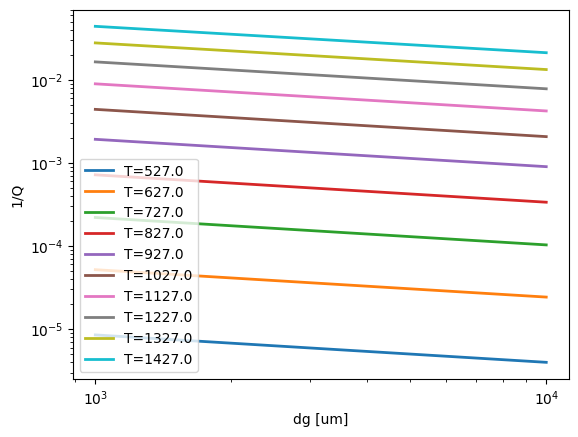

In [4]:
import matplotlib.pyplot as plt

nT = vbr.input.SV.T_K.shape[0]
ig = 0  # grain size index to use
phi = vbr.input.SV.phi[0, :, 0]
dg = vbr.input.SV.dg_um[0, 0, :]
T_C = vbr.input.SV.T_K[:, 0, 0] - 273.0
ifreq = 0  # frequency index to use

for iT in range(nT):
    Qinv = vbr.output.anelastic.andrade_psp.Qinv[iT, 0, :, 0]  # extra dim for frequency
    plt.loglog(dg, Qinv, label=f"T={T_C[iT]}", linewidth=2)
plt.xlabel("dg [um]")
plt.ylabel("1/Q")
plt.legend()
plt.show()


We can also plot temperature dependence by simply extracting values along the temperature index:

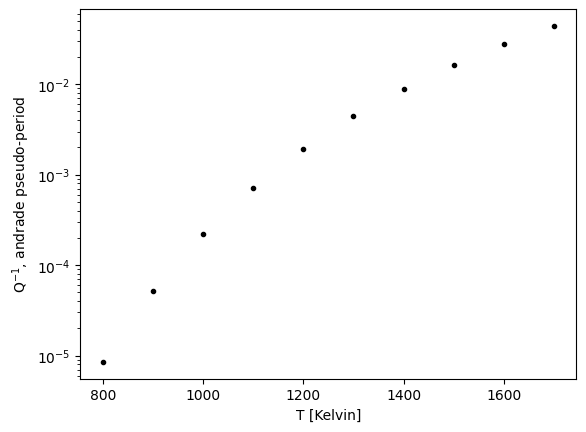

In [5]:
T_K = vbr.input.SV.T_K[:, 0, 0]
Qinv = vbr.output.anelastic.andrade_psp.Qinv[:, 0, 0, 0]

f = plt.figure()
plt.semilogy(T_K, Qinv, ".k")
plt.xlabel("T [Kelvin]")
plt.ylabel("Q$^{-1}$, andrade pseudo-period")
f.savefig('andrade_psp_T_dep.png')